In [1]:
# Загрузка нужных библиотек
import numpy as np
import pandas as pd
import re

from IPython.display import Image, display

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro
import scipy.stats as stats

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
# Загрузка данных
df = pd.read_csv('data/df.csv')

#df.date = pd.to_datetime(df.date)
df.head()

,contract_date,project_name,grant_recipient,amount,global_id
0,2018-02-01,"Финансовое обеспечение деятельности, включая и...",Автономная некоммерческая организация «Московс...,4.930874e+08,859838603
1,2018-02-01,Проведение мероприятий по развитию конгрессно-...,"АНО Центр содействия развитию науки, промышлен...",1.142289e+09,859912894
2,2018-03-15,"Субсидия на финансовое обеспечение расходов, с...",Некоммерческая организация Фонд развития Центр...,6.000000e+07,859994234
3,2015-12-18,"Оснащение ЦМИТ «Цифровой дом», специализирующе...",Общество с ограниченной ответственностью «Меди...,5.624718e+06,861525641
4,2015-12-18,Техническое перевооружение АО «МПО им. И.Румян...,Акционерное общество «Машиностроительное произ...,2.924794e+07,861525767


## 3. Провести исследование распределений размеров грантов для различных проектов. Распределения похожи или различаются?

### 3.1. Подготовка данных для исследования

Для исследования будем использовать 10 проектов с наибольшим количеством грантов.

In [3]:
columns_to_use = df.groupby('project_name')['amount'] \
                   .agg(['count','mean','median']) \
                   .sort_values(by='count', ascending=False).head(10).index

columns_to_use = list(columns_to_use)
columns_to_use

['Предоставление субсидии субъектам малого и среднего предпринимательства в целях возмещения части затрат на оплату коммунальных услуг',
 'Предоставление гранта в целях поддержки субъектов предпринимательской деятельности, осуществляющих деятельность в сфере быстрого питания, в целях открытия на территории города Москвы места предоставления услуг быстрого питания',
 'Предоставление субсидии на возмещение части затрат, связанных с получением обучающимися среднего профессионального образования и дополнительного профессионального образования',
 'Предоставление гранта на поддержку деятельности получателя в сфере обрабатывающих и высокотехнологичных отраслей экономики на финансовое возмещение затрат по приобретению оборудования',
 'Предоставление субсидии в целях возмещения части документально подтвержденных затрат Получателя, связанных с продвижением товаров собственного производства, выполнением работ и оказанием услуг (компенсация оплаты услуг сервисов по доставке продуктов питания)',
 '

Запишем нужные данные в отдельный датафрейм.

В датафрейме для исследования будет использовано 4326 записей.

In [4]:
df_to_test = df[df['project_name'].isin(columns_to_use)][['project_name', 'amount']]

print(df_to_test.shape)
df_to_test

(4326, 2)


,project_name,amount
849,Предоставление гранта в целях стимулирования р...,343788.50
850,Предоставление гранта в целях стимулирования р...,2345248.52
851,Предоставление гранта в целях стимулирования р...,4153202.00
853,Предоставление гранта в целях стимулирования р...,6726513.50
1357,Предоставление гранта в целях стимулирования р...,9446941.00
...,...,...
9929,Предоставление субсидии на возмещение части за...,114000.00
9930,Предоставление субсидии на возмещение части за...,38000.00
9931,Предоставление субсидии на возмещение части за...,46800.00
9932,Предоставление субсидии на возмещение части за...,110200.00


Проекты имеют длинные и неудобные названия, поэтому сделаем их короче, сохранив при этом суть.

In [5]:
df_to_test['project_name'] = df_to_test['project_name'].replace(
    {'Предоставление субсидии субъектам малого и среднего предпринимательства в целях возмещения части затрат на оплату коммунальных услуг': 'Возмещение оплаты комм. услуг',
     'Предоставление гранта в целях поддержки субъектов предпринимательской деятельности, осуществляющих деятельность в сфере быстрого питания, в целях открытия на территории города Москвы места предоставления услуг быстрого питания': 'Гранты в сфере быстрого питания',
     'Предоставление субсидии на возмещение части затрат, связанных с получением обучающимися среднего профессионального образования и дополнительного профессионального образования': 'Частичная оплата образования',
     'Предоставление гранта на поддержку деятельности получателя в сфере обрабатывающих и высокотехнологичных отраслей экономики на финансовое возмещение затрат по приобретению оборудования': 'Приобретение оборудования в высокотехнологических отраслях',
     'Предоставление субсидии в целях возмещения части документально подтвержденных затрат Получателя, связанных с продвижением товаров собственного производства, выполнением работ и оказанием услуг (компенсация оплаты услуг сервисов по доставке продуктов питания)': 'Возмещение оплаты услуг сервисов по доставке продуктов',
     'предоставление субсидии в целях возмещения части фактически произведенных и документально подтвержденных затрат Получателя на выплату вознаграждений по договору коммерческой концессии, на приобретение оборудования': 'Приобретение оборудования',
     'Предоставление субсидии в целях возмещения части фактически произведенных и документально подтвержденных затрат Получателя на выплату вознаграждений по договору коммерческой концессии (роялти)': 'Возмещение оплаты роялти',
     'Предоставление субсидии в целях возмещения части документально подтвержденных затрат Получателя, связанных с продвижением товаров собственного производства, выполнением работ и оказанием услуг (реклама)': 'Возмещение оплаты рекламы',
     'предоставление субсидии в целях возмещения части документально подтвержденных затрат Получателя, связанных с продвижением товаров собственного производства, выполнением работ и оказанием (доставка)': 'Возмещение оплаты доставки',
     'Предоставление гранта в целях стимулирования развития деятельности субъектов малого и среднего предпринимательства, осуществляющих реализацию товаров за пределы территории Российской Федерации, экспорт результатов интеллектуальной деятельности и (или) услуг': 'Гранты для производства товаров на экспорт'}
     )

Посмотрим на распределения грантов по исследуемым проектам.

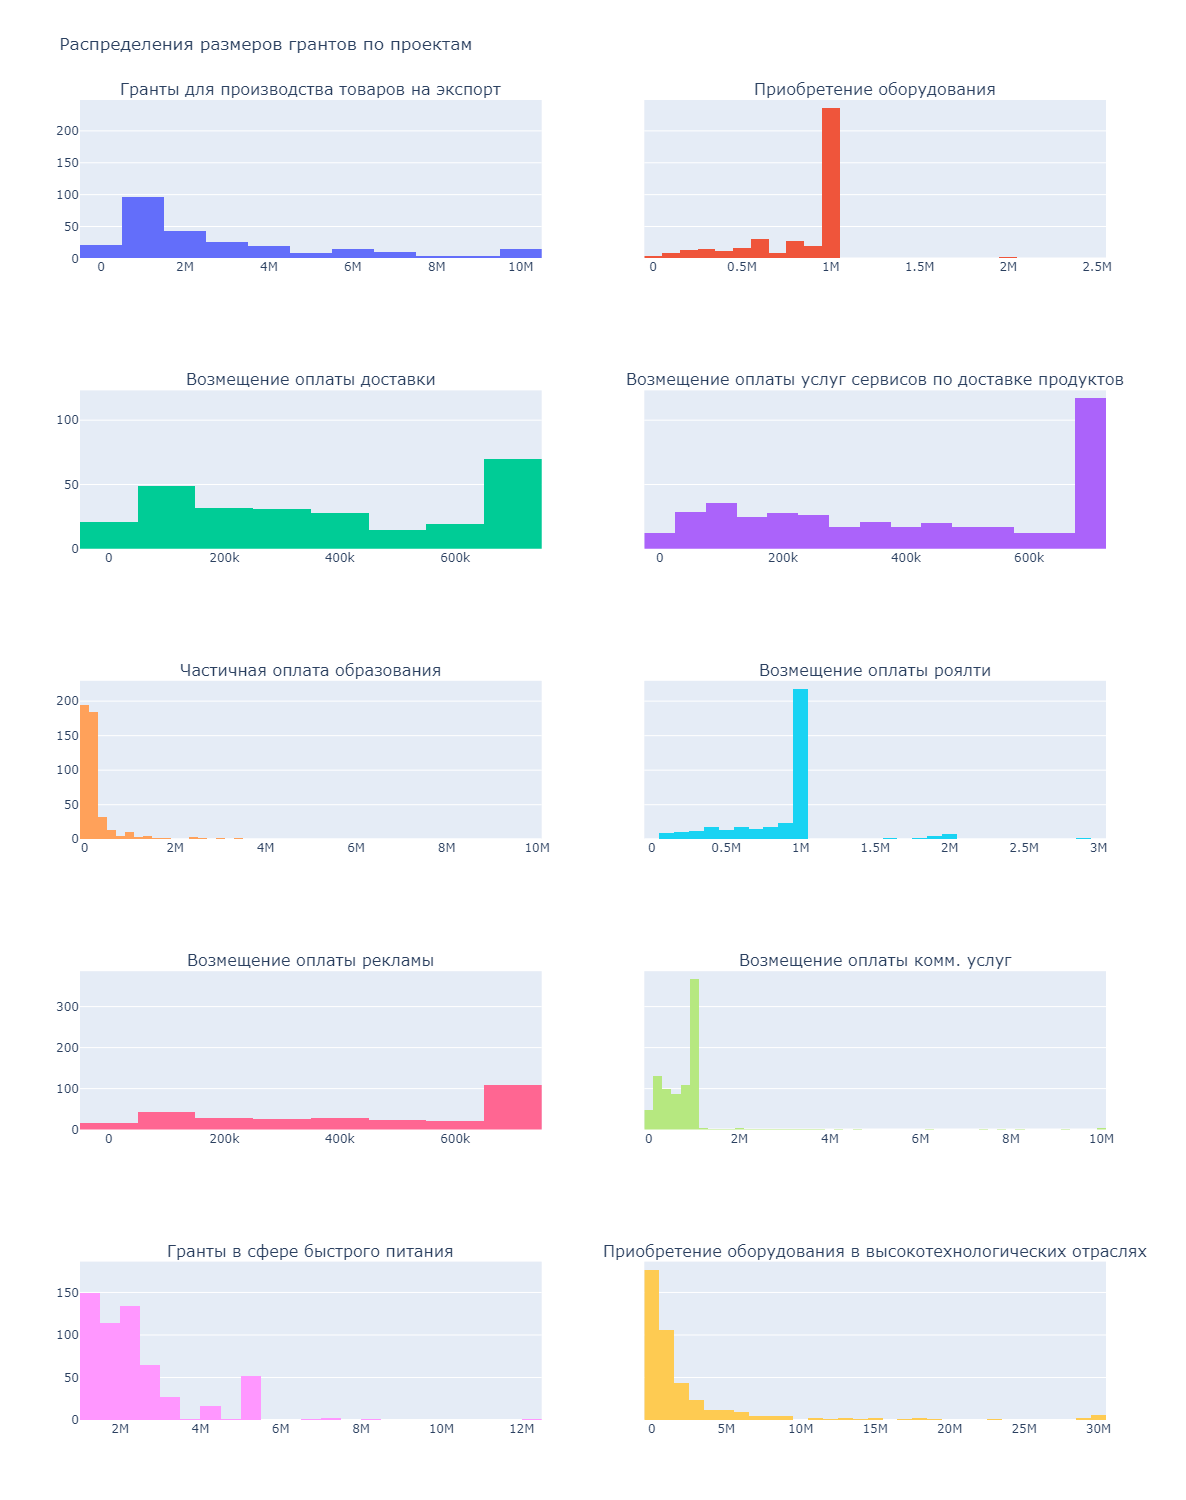

In [6]:
projects = list(df_to_test['project_name'].unique())

fig = make_subplots(rows=5,
                    cols=2,
                    shared_yaxes=True,
                    subplot_titles=projects)

row=1
col=1

for project in projects:
    fig.append_trace(go.Histogram(x=df_to_test[df_to_test['project_name'] == project]['amount'], name=project), row, col)

    if col % 2 == 0:
        row+=1
        col=0

    col+=1

fig.update_layout(title='Распределения размеров грантов по проектам',
                  height=1500,
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False)
fig.show()

display(Image(filename='img/grants_distribution.png', width=800))

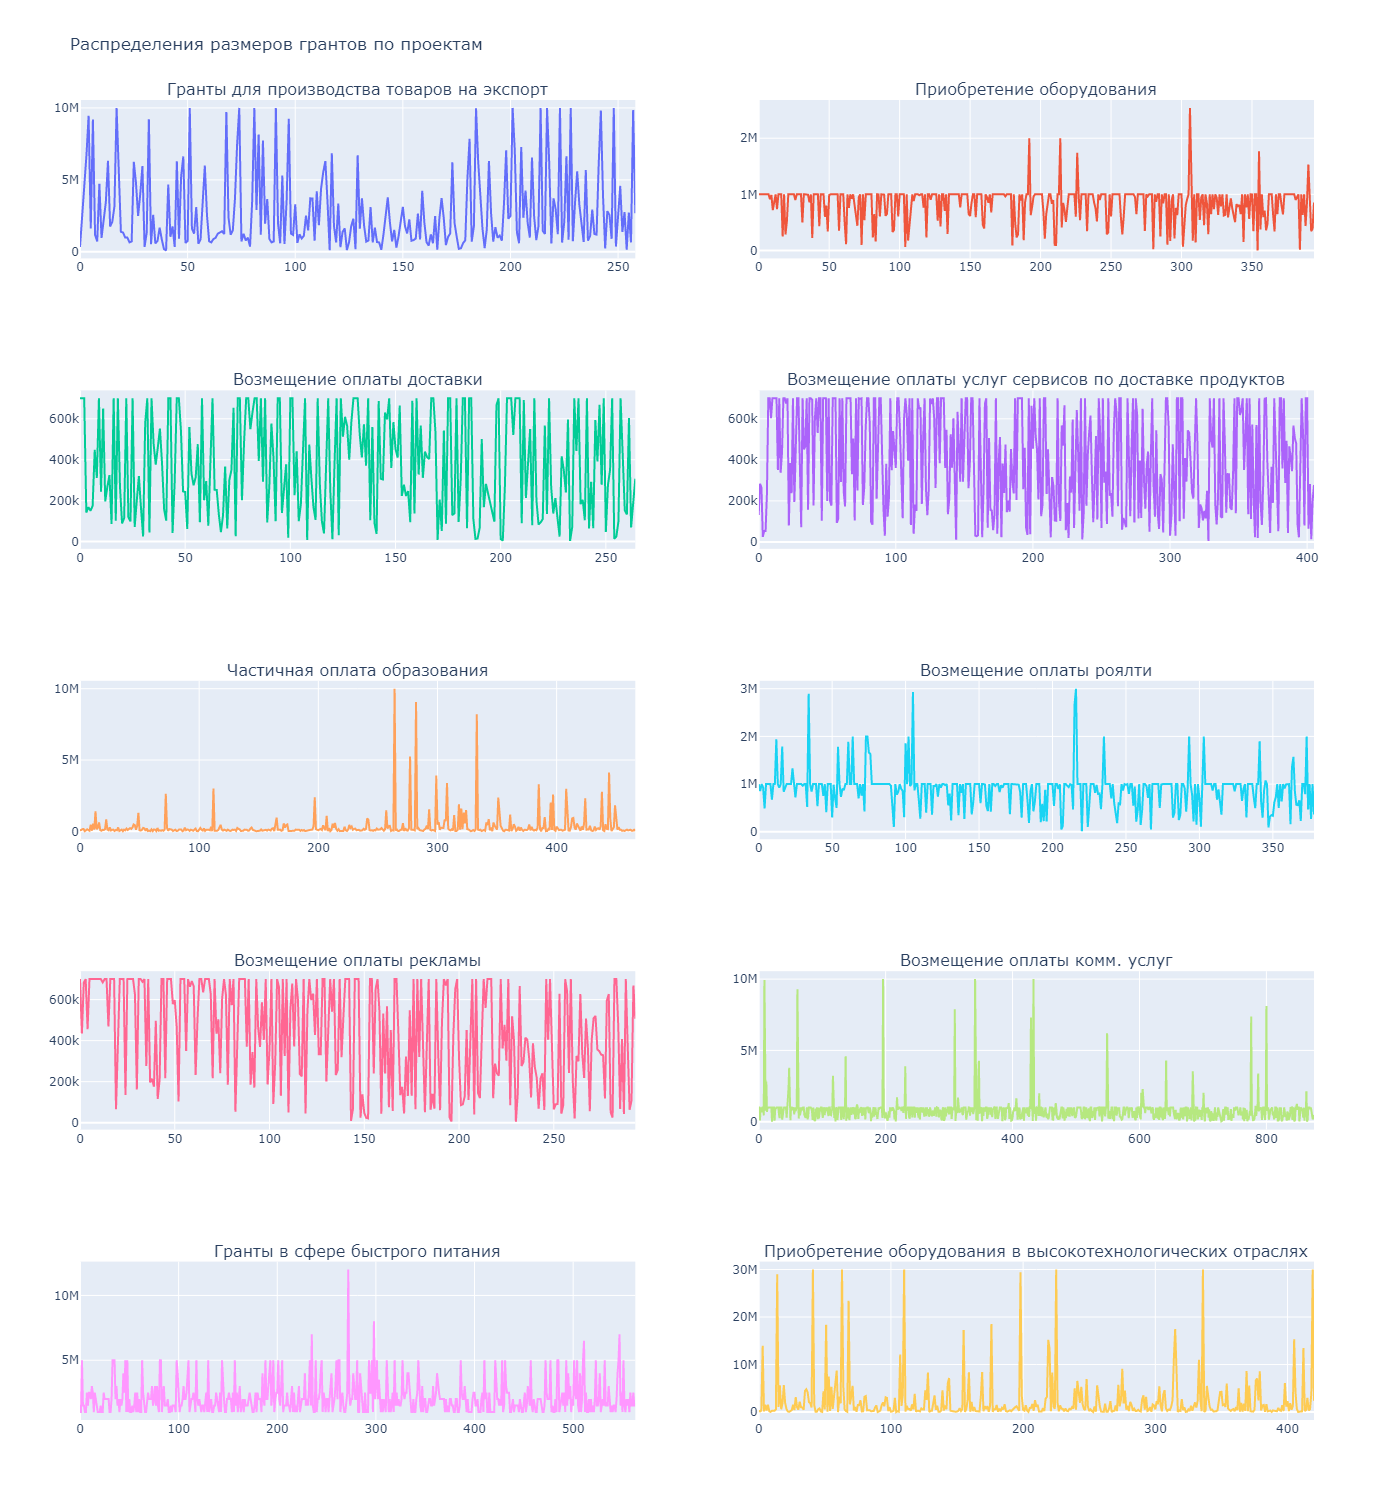

In [7]:
fig = make_subplots(rows=5,
                    cols=2,
                    shared_yaxes=False,
                    subplot_titles=projects)

row=1
col=1

for project in projects:
    fig.add_trace(go.Scatter(y=df_to_test[df_to_test['project_name'] == project]['amount'], name=project), row, col)

    if col % 2 == 0:
        row+=1
        col=0

    col+=1

fig.update_layout(title='Распределения размеров грантов по проектам',
                  height=1500,
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False)
fig.show()

display(Image(filename='img/grants_distribution_by_project.png', width=800))

### 3.2. Проверка гипотезы о нормальности распределения данных

По виду гистограмм можно заметить, что распределение у данных не нормальное. На графиках scatter plot видно, что в данных есть выбросы.

Проверим, нормально ли распределены данные, используем тест Шапиро-Уилка.

Нулевая гипотеза для теста Шапиро-Уилка H0: случайная величина распределена НОРМАЛЬНО.

Альтернативная гипотеза H1: случайная величина распределена НЕ НОРМАЛЬНО.

In [8]:
for project in projects:
    print(project)

    amount = df_to_test[df_to_test['project_name'] == project]['amount']
    shapiro_p_val = shapiro(amount)[1]

    if shapiro_p_val < 0.05:
        print('Распределение не нормальное')
    else:
        print('Распределение нормальное')

    print(f'p-value - {shapiro(amount)[1]}')

    print('#################################################', '\n')

Гранты для производства товаров на экспорт
Распределение не нормальное
p-value - 3.9826754643513255e-17
################################################# 

Приобретение оборудования
Распределение не нормальное
p-value - 3.654332667981204e-24
################################################# 

Возмещение оплаты доставки
Распределение не нормальное
p-value - 2.353148329404392e-13
################################################# 

Возмещение оплаты услуг сервисов по доставке продуктов
Распределение не нормальное
p-value - 1.3778021554134436e-17
################################################# 

Частичная оплата образования
Распределение не нормальное
p-value - 3.882095888692736e-38
################################################# 

Возмещение оплаты роялти
Распределение не нормальное
p-value - 2.3257112010748106e-23
################################################# 

Возмещение оплаты рекламы
Распределение не нормальное
p-value - 4.882099384626774e-16
##################################

### 3.3. Проверка гипотезы о нормальности распределения данных после логарифмирования

Тест Шапиро-Уилка показывает маленькие значения p-value, это говорит о том, что данные распределены не нормально.

Для большей достоверности при проверке гипотез о различиях в размерах грантов будет лучше, если данные будут иметь нормальное распределение.

Попробуем прологарифмировать данные, а затем посмотрим на получающиеся распределения.

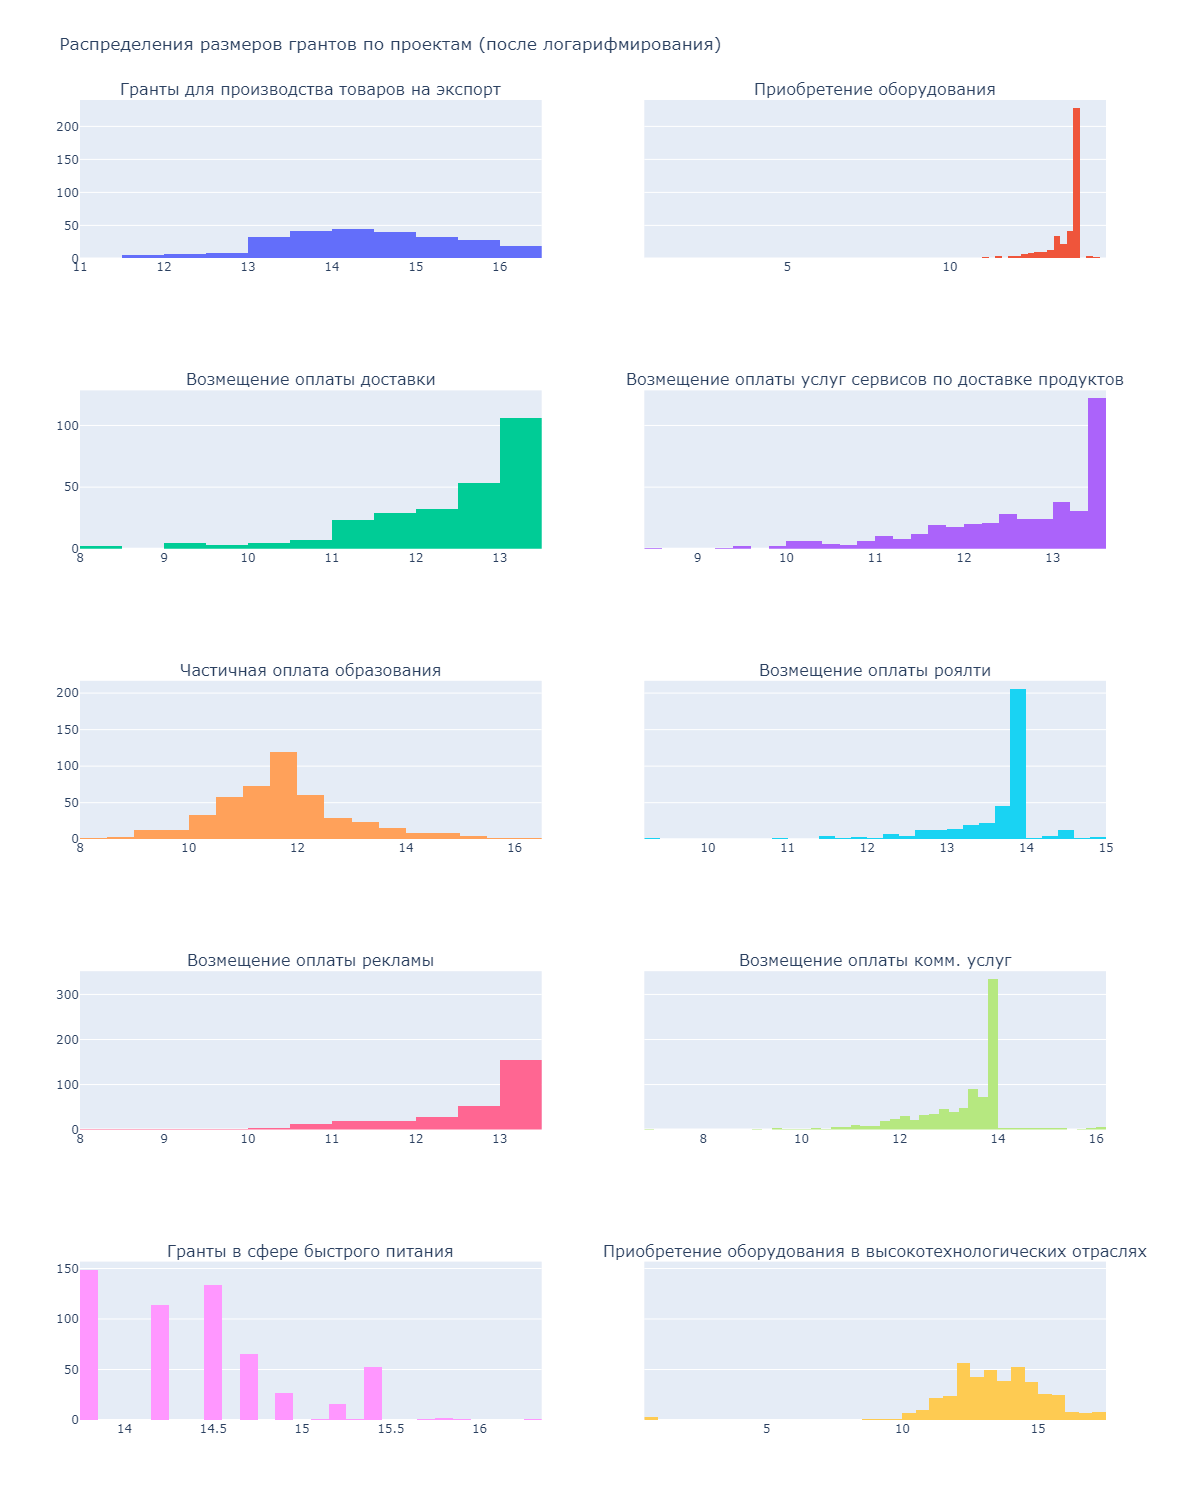

In [9]:
projects = list(df_to_test['project_name'].unique())

fig = make_subplots(rows=5,
                    cols=2,
                    shared_yaxes=True,
                    subplot_titles=projects)

row=1
col=1

for project in projects:
    fig.append_trace(go.Histogram(x=np.log1p(df_to_test[df_to_test['project_name'] == project]['amount']), name=project), row, col)

    if col % 2 == 0:
        row+=1
        col=0

    col+=1

fig.update_layout(title='Распределения размеров грантов по проектам (после логарифмирования)',
                  height=1500,
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False)
fig.show()

display(Image(filename='img/grants_distribution_by_project_log.png', width=800))

Посмотрим на результаты теста Шапиро-Уилка для логарифмированных данных.

In [10]:
for project in projects:
    print(project)

    amount = np.log1p(df_to_test[df_to_test['project_name'] == project]['amount'])
    shapiro_p_val = shapiro(amount)[1]

    if shapiro_p_val < 0.05:
        print('Распределение не нормальное')
    else:
        print('Распределение нормальное')

    print(f'p-value - {shapiro(amount)[1]}')

    print('#################################################', '\n')

Гранты для производства товаров на экспорт
Распределение не нормальное
p-value - 0.0003170721174683422
################################################# 

Приобретение оборудования
Распределение не нормальное
p-value - 5.418228151764248e-34
################################################# 

Возмещение оплаты доставки
Распределение не нормальное
p-value - 3.3607054974598176e-15
################################################# 

Возмещение оплаты услуг сервисов по доставке продуктов
Распределение не нормальное
p-value - 2.237245417474969e-19
################################################# 

Частичная оплата образования
Распределение не нормальное
p-value - 2.0038038783809498e-08
################################################# 

Возмещение оплаты роялти
Распределение не нормальное
p-value - 3.0717425206117033e-25
################################################# 

Возмещение оплаты рекламы
Распределение не нормальное
p-value - 3.4384000718299317e-19
#################################

### 3.4. Поиск и удаление выбросов

Получить нормально распределенные данные не удалось, мы также получаем низкий уровень p-value.

Посмотрим на то, как будет выглядеть распределение данных, если найти и исключить выбросы.

Для определения выбросов будем использовать фильтр Хэмпеля. Данный фильтр будет считать выбросами все значения, у которых разница с медианой больше, чем три медианных абсолютных отклонения.

In [11]:
def hampel(vals_orig):
    '''
    В этой функции реализован фильтр Хэмпеля.
    На вход принимаются числовые значения (грантов).
    Функция возвращает проиндексированные результаты теста (True - выброс, False - нормальное значение).
    '''
    vals = vals_orig.copy()    
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = 3 * median_abs_deviation
    outlier_idx = difference > threshold
    return outlier_idx

Отсортируем данные по названиям проектов. После чего передадим функции hampel поочередно значения грантов для каждого проекта. Затем результаты соберем в датафрейм hampel_test_result. В этом датафрейме в колонке is_outlier будут содержаться результаты теста для каждого значения в исходном датафрейме.

In [12]:
df_to_test = df_to_test.sort_values(by='project_name').reset_index(drop=True)
df_to_test

,project_name,amount
0,Возмещение оплаты доставки,80331.20
1,Возмещение оплаты доставки,531950.75
2,Возмещение оплаты доставки,8263.60
3,Возмещение оплаты доставки,205706.90
4,Возмещение оплаты доставки,51702.20
...,...,...
4321,Частичная оплата образования,69350.00
4322,Частичная оплата образования,270750.00
4323,Частичная оплата образования,21375.00
4324,Частичная оплата образования,150000.00


In [13]:
projects = list(df_to_test['project_name'].unique())

hampel_test_result = pd.DataFrame(columns=['project_name', 'is_outlier']) # создаем пустой датафрейм

for project in projects:
    hampel_res = hampel(df_to_test[df_to_test['project_name'] == project]['amount']) # получаем результаты теста

    project_df = pd.DataFrame({'project_name': project, 'is_outlier': hampel_res}) # записываем проект и результаты теста в отдельный датафрейм

    hampel_test_result = pd.concat([hampel_test_result, project_df], ignore_index=True) # добавляем результаты по проекту в общий датафрейм

hampel_test_result

,project_name,is_outlier
0,Возмещение оплаты доставки,False
1,Возмещение оплаты доставки,False
2,Возмещение оплаты доставки,False
3,Возмещение оплаты доставки,False
4,Возмещение оплаты доставки,False
...,...,...
4321,Частичная оплата образования,False
4322,Частичная оплата образования,False
4323,Частичная оплата образования,False
4324,Частичная оплата образования,False


Все ли значения были протестированы?

In [14]:
df_to_test.shape[0] == hampel_test_result.shape[0]

True

Добавим колонку is_outlier в исследуемый датафрейм.

In [15]:
df_to_test['is_outlier'] = hampel_test_result['is_outlier']
df_to_test

,project_name,amount,is_outlier
0,Возмещение оплаты доставки,80331.20,False
1,Возмещение оплаты доставки,531950.75,False
2,Возмещение оплаты доставки,8263.60,False
3,Возмещение оплаты доставки,205706.90,False
4,Возмещение оплаты доставки,51702.20,False
...,...,...,...
4321,Частичная оплата образования,69350.00,False
4322,Частичная оплата образования,270750.00,False
4323,Частичная оплата образования,21375.00,False
4324,Частичная оплата образования,150000.00,False


Запишем в отдельный датафрейм данные без выбросов.

In [16]:
df_no_outliers = df_to_test[df_to_test['is_outlier'] == False]
df_no_outliers

,project_name,amount,is_outlier
0,Возмещение оплаты доставки,80331.20,False
1,Возмещение оплаты доставки,531950.75,False
2,Возмещение оплаты доставки,8263.60,False
3,Возмещение оплаты доставки,205706.90,False
4,Возмещение оплаты доставки,51702.20,False
...,...,...,...
4321,Частичная оплата образования,69350.00,False
4322,Частичная оплата образования,270750.00,False
4323,Частичная оплата образования,21375.00,False
4324,Частичная оплата образования,150000.00,False


Посмотрим, какой процент от всех данных был исключен.

In [17]:
print(f'Из выборки было исключено {100 - round((df_no_outliers.shape[0] / df_to_test.shape[0]) * 100)}% данных.')

Из выборки было исключено 20% данных.


Какой процент данных был исключен по каждому проекту?

In [18]:
df_before = df_to_test.groupby('project_name')['amount'].agg('count').reset_index()
df_before = df_before.rename(columns={'amount': 'count_before'})
df_before

,project_name,count_before
0,Возмещение оплаты доставки,265
1,Возмещение оплаты комм. услуг,876
2,Возмещение оплаты рекламы,294
3,Возмещение оплаты роялти,379
4,Возмещение оплаты услуг сервисов по доставке п...,406
5,Гранты в сфере быстрого питания,564
6,Гранты для производства товаров на экспорт,259
7,Приобретение оборудования,395
8,Приобретение оборудования в высокотехнологичес...,421
9,Частичная оплата образования,467


In [19]:
df_after = df_no_outliers.groupby('project_name')['amount'].agg('count').reset_index()
df_after = df_after.rename(columns={'amount': 'count_after'})
df_after

,project_name,count_after
0,Возмещение оплаты доставки,265
1,Возмещение оплаты комм. услуг,695
2,Возмещение оплаты рекламы,294
3,Возмещение оплаты роялти,197
4,Возмещение оплаты услуг сервисов по доставке п...,406
5,Гранты в сфере быстрого питания,490
6,Гранты для производства товаров на экспорт,209
7,Приобретение оборудования,220
8,Приобретение оборудования в высокотехнологичес...,322
9,Частичная оплата образования,382


In [20]:
full_count = df_before.merge(df_after)
full_count['removed_percentage'] = 100 - round((full_count['count_after'] / full_count['count_before']) * 100)
full_count[['project_name', 'removed_percentage']]

,project_name,removed_percentage
0,Возмещение оплаты доставки,0.0
1,Возмещение оплаты комм. услуг,21.0
2,Возмещение оплаты рекламы,0.0
3,Возмещение оплаты роялти,48.0
4,Возмещение оплаты услуг сервисов по доставке п...,0.0
5,Гранты в сфере быстрого питания,13.0
6,Гранты для производства товаров на экспорт,19.0
7,Приобретение оборудования,44.0
8,Приобретение оборудования в высокотехнологичес...,24.0
9,Частичная оплата образования,18.0


Наибольший процент данных был исключен из проекта "Возмещение оплаты роялти" (48%), при этом есть проекты, в которых тест Хэмпеля не обнаружил выбросов.

Посмотрим на распределение данных без выбросов.

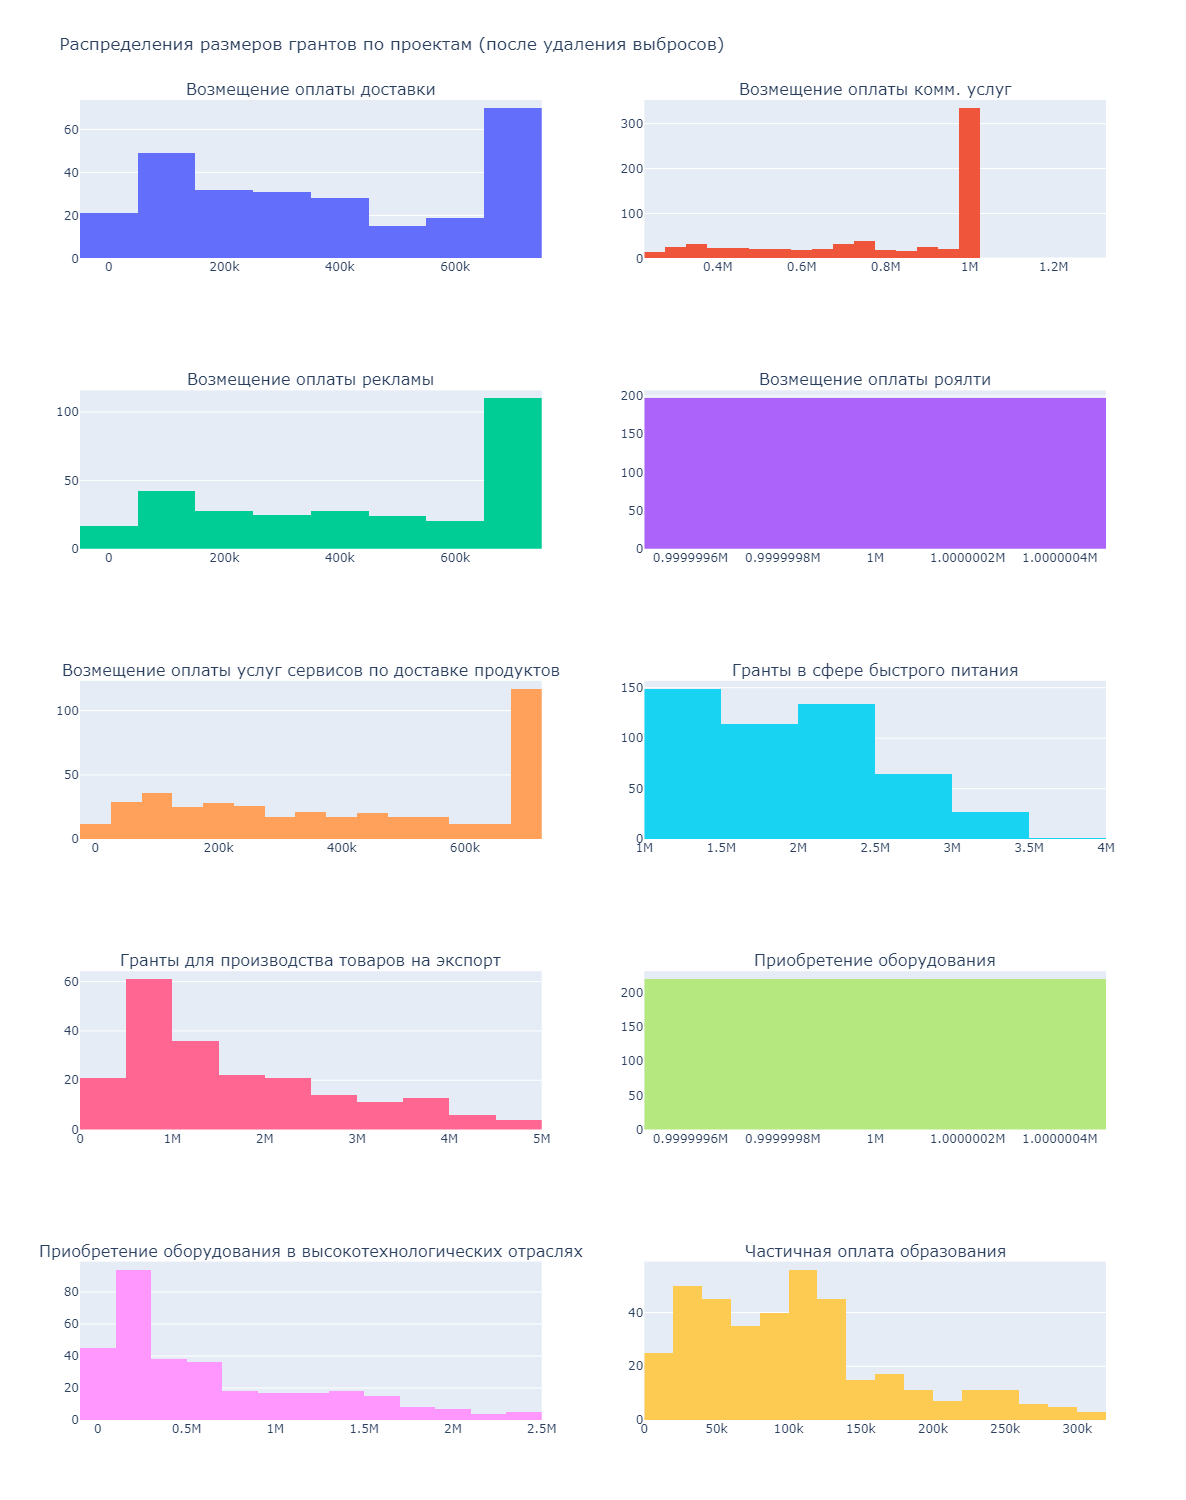

In [21]:
projects = list(df_no_outliers['project_name'].unique())

fig = make_subplots(rows=5,
                    cols=2,
                    shared_yaxes=False,
                    subplot_titles=projects)

row=1
col=1

for project in projects:
    fig.append_trace(go.Histogram(x=df_no_outliers[df_no_outliers['project_name'] == project]['amount'], name=project), row, col)

    if col % 2 == 0:
        row+=1
        col=0

    col+=1

fig.update_layout(title='Распределения размеров грантов по проектам (после удаления выбросов)',
                  height=1500,
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False)
fig.show()

display(Image(filename='img/grants_distribution_by_project_no_outliers.png', width=800))

### 3.5. Применение критерия Манна-Уитни

На графиках видно, что есть проекты со схожими распределениями. Применим к таким проектам критерий Манна-Уитни.

Нулевая гипотеза H0: Средние равны

Альтернативная гипотеза H1: Средние не равны

#### 3.5.1. Проект 1 - Возмещение оплаты доставки; Проект 2 - Возмещение оплаты рекламы

Проекты имеют очень похожее распределение, выбросов в данных обнаружено не было.

Оба рспределения бимодальны, при этом численно моды отличаются.

Получен p-value - 0.002684934023946172, значит различия между группами статистически значимы.

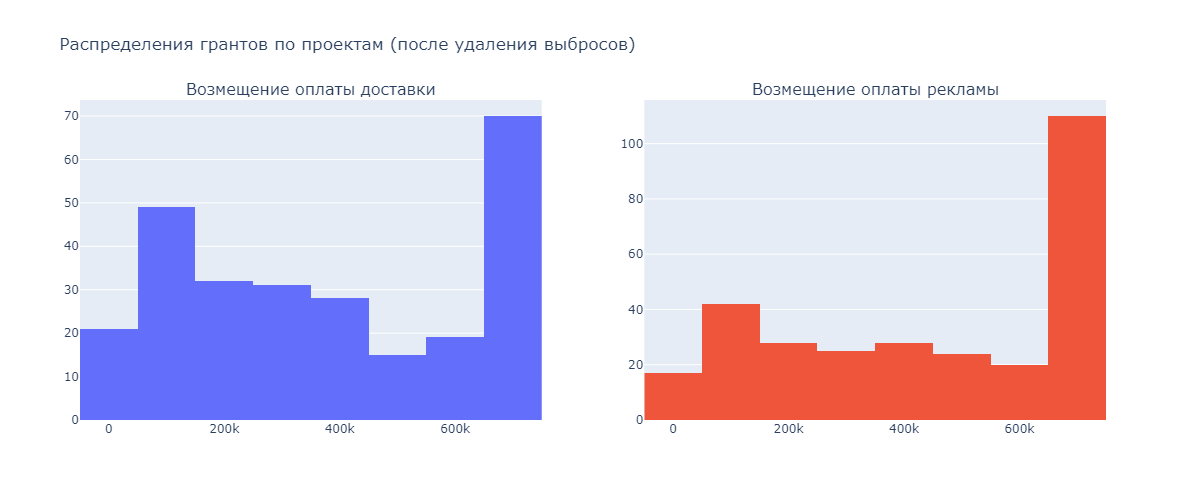

In [22]:
fig = make_subplots(rows=1,
                    cols=2,
                    shared_yaxes=False,
                    subplot_titles=['Возмещение оплаты доставки', 'Возмещение оплаты рекламы'])

fig.append_trace(go.Histogram(x=df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты доставки']['amount'],
                              name='Возмещение оплаты доставки'), 
                              1, 1)

fig.append_trace(go.Histogram(x=df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты рекламы']['amount'],
                              name='Возмещение оплаты рекламы'),
                              1, 2)

fig.update_layout(title='Распределения грантов по проектам (после удаления выбросов)',
                  height=500,
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False)
fig.show()

display(Image(filename='img/delivery_ads.png', width=800))

In [23]:
test_result = stats.mannwhitneyu(df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты доставки']['amount'], 
                                 df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты рекламы']['amount'])[1]

test_result

0.002684934023946172

#### 3.5.2. Проект 1 - Возмещение оплаты роялти; Проект 2 - Приобретение оборудования

Распределения практически идентичны, но при этом для Проекта 1 48% данных были определены как выбросы и удалены, а для Проекта 2 процент удаленных данных составил 44%.

Получен выскоий уровень p-value, что говорит о равенстве средних, но слишком большой процент данных был удален.

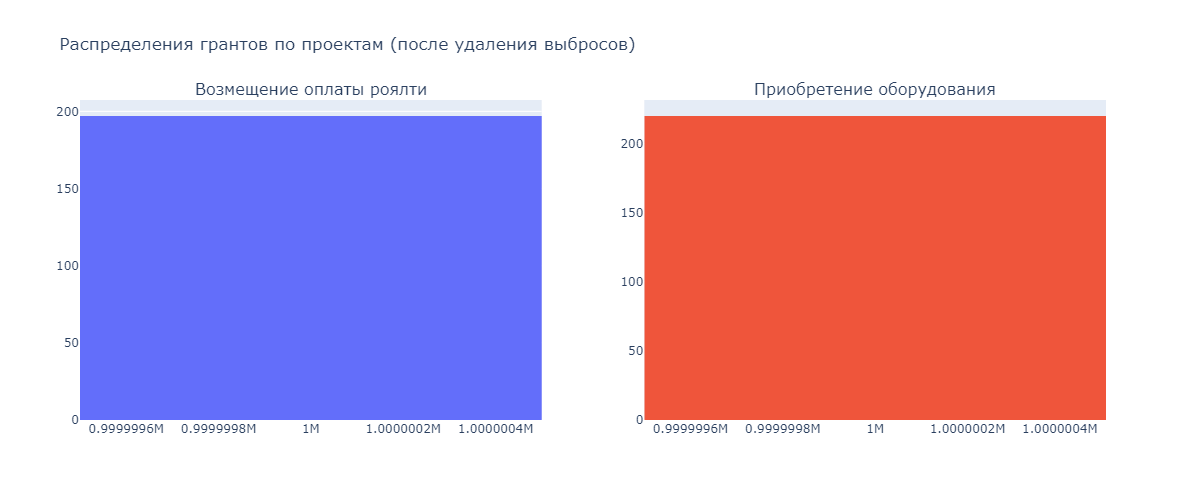

In [24]:
projects = list(df_no_outliers['project_name'].unique())

fig = make_subplots(rows=1,
                    cols=2,
                    shared_yaxes=False,
                    subplot_titles=['Возмещение оплаты роялти', 'Приобретение оборудования'])

fig.append_trace(go.Histogram(x=df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты роялти']['amount'],
                              name='Возмещение оплаты роялти'), 
                              1, 1)

fig.append_trace(go.Histogram(x=df_no_outliers[df_no_outliers['project_name'] == 'Приобретение оборудования']['amount'],
                              name='Приобретение оборудования'),
                              1, 2)

fig.update_layout(title='Распределения грантов по проектам (после удаления выбросов)',
                  height=500,
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False)
fig.show()

display(Image(filename='img/royalty_equipment.png', width=800))

In [25]:
test_result = stats.mannwhitneyu(df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты роялти']['amount'], 
                                 df_no_outliers[df_no_outliers['project_name'] == 'Приобретение оборудования']['amount'])[1]

test_result

1.0

Применим критерий Манна-Уитни на данных с выбросами. Данные с выбросами также имеют схожее унимодальное распределение.

Получен высокий уровен p-value - 0.22711295743276472, значит нет оснований отвергнуть нулевую гипотезу и в данном случае средние двух групп не различаются.

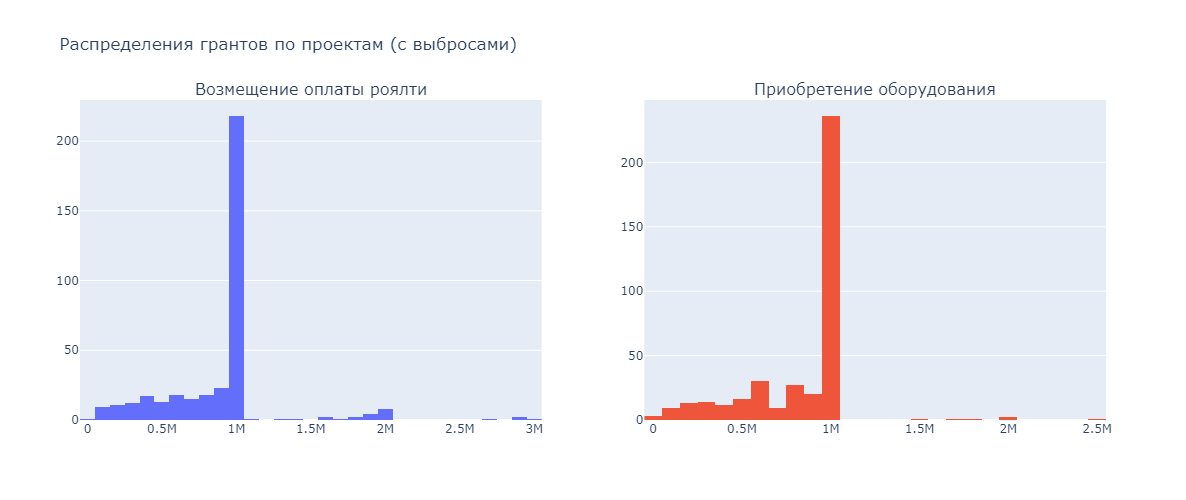

In [26]:
fig = make_subplots(rows=1,
                    cols=2,
                    shared_yaxes=False,
                    subplot_titles=['Возмещение оплаты роялти', 'Приобретение оборудования'])

fig.append_trace(go.Histogram(x=df_to_test[df_to_test['project_name'] == 'Возмещение оплаты роялти']['amount'],
                              name='Возмещение оплаты роялти'), 
                              1, 1)

fig.append_trace(go.Histogram(x=df_to_test[df_to_test['project_name'] == 'Приобретение оборудования']['amount'],
                              name='Приобретение оборудования'),
                              1, 2)

fig.update_layout(title='Распределения грантов по проектам (с выбросами)',
                  height=500,
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False)
fig.show()

display(Image(filename='img/royalty_equipment_outliers.png', width=800))

In [27]:
test_result = stats.mannwhitneyu(df_to_test[df_to_test['project_name'] == 'Возмещение оплаты роялти']['amount'], 
                                 df_to_test[df_to_test['project_name'] == 'Приобретение оборудования']['amount'])[1]

test_result

0.22711295743276472

#### 3.5.3. Проект 1 - Возмещение оплаты доставки; Проект 2 - Возмещение оплаты услуг сервисов по доставке продуктов

Оба проекта связаны с доставкой. Ни в одном из данных проектов не было обнаружено выбросов.

Высокий уровень p-value не позволяет отклонить нулевую гипотезу о равенстве средних.

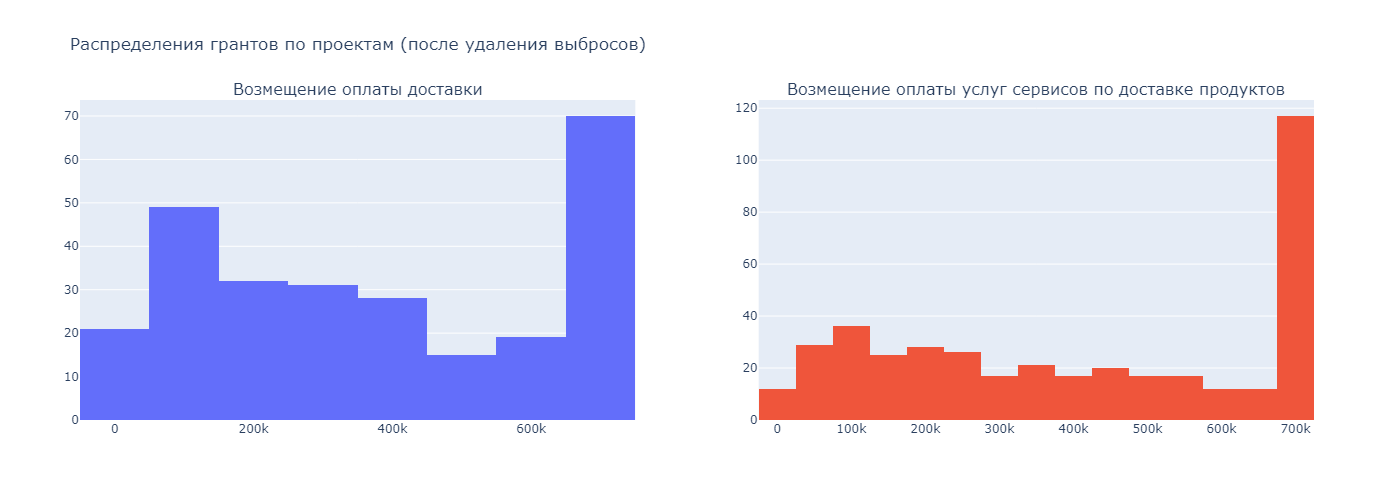

In [28]:
fig = make_subplots(rows=1,
                    cols=2,
                    shared_yaxes=False,
                    subplot_titles=['Возмещение оплаты доставки', 'Возмещение оплаты услуг сервисов по доставке продуктов'])

fig.append_trace(go.Histogram(x=df_to_test[df_to_test['project_name'] == 'Возмещение оплаты доставки']['amount'],
                              name='Возмещение оплаты доставки'), 
                              1, 1)

fig.append_trace(go.Histogram(x=df_to_test[df_to_test['project_name'] == 'Возмещение оплаты услуг сервисов по доставке продуктов']['amount'],
                              name='Возмещение оплаты услуг сервисов по доставке продуктов'),
                              1, 2)

fig.update_layout(title='Распределения грантов по проектам (после удаления выбросов)',
                  height=500,
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False)
fig.show()

display(Image(filename='img/delivery_products_delivery.png', width=800))

In [29]:
test_result = stats.mannwhitneyu(df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты доставки']['amount'], 
                                 df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты услуг сервисов по доставке продуктов']['amount'])[1]

test_result

0.13276689865666597

#### 3.5.4. Проект 1 - Возмещение оплаты рекламы; Проект 2 - Возмещение оплаты услуг сервисов по доставке продуктов

Ни в одном из данных проектов не было обнаружено выбросов.

Уровень p-value больше 0.05 не позволяет отклонить нулевую гипотезу о равенстве средних.

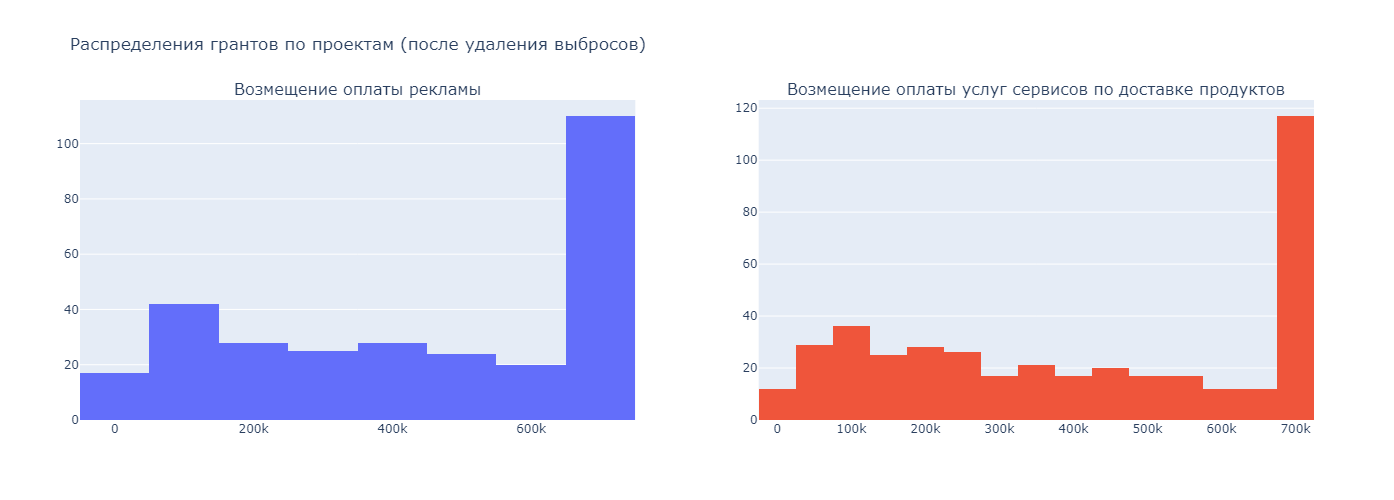

In [30]:
fig = make_subplots(rows=1,
                    cols=2,
                    shared_yaxes=False,
                    subplot_titles=['Возмещение оплаты рекламы', 'Возмещение оплаты услуг сервисов по доставке продуктов'])

fig.append_trace(go.Histogram(x=df_to_test[df_to_test['project_name'] == 'Возмещение оплаты рекламы']['amount'],
                              name='Возмещение оплаты рекламы'), 
                              1, 1)

fig.append_trace(go.Histogram(x=df_to_test[df_to_test['project_name'] == 'Возмещение оплаты услуг сервисов по доставке продуктов']['amount'],
                              name='Возмещение оплаты услуг сервисов по доставке продуктов'),
                              1, 2)

fig.update_layout(title='Распределения грантов по проектам (после удаления выбросов)',
                  height=500,
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=False)
fig.show()

display(Image(filename='img/ads_products_delivery.png', width=800))

In [31]:
test_result = stats.mannwhitneyu(df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты рекламы']['amount'], 
                                 df_no_outliers[df_no_outliers['project_name'] == 'Возмещение оплаты услуг сервисов по доставке продуктов']['amount'])[1]

test_result

0.07063644258912083

### 3.6. Применение критерия Тьюки

Попарно сравним все группы, используя критерий Тьюки.

Нулевая гипотеза H0: Средние двух групп равны.

Альтернативная гипотеза H1: Средние двух групп отличаются.

Проведем тесты для данных с выбросами и без выбросов. Посмотрим на пары, для которых нулевая гипотеза не была отклонена.

In [32]:
# Тест для данных с выбросами
a = 0.05

tukey = pairwise_tukeyhsd(endog=df_to_test['amount'],
                          groups=df_to_test['project_name'],
                          alpha=a)

df_tukey = pd.DataFrame(data=tukey._results_table.data[1:], columns = tukey._results_table.data[0])

df_tukey

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Возмещение оплаты доставки,Возмещение оплаты комм. услуг,4.456287e+05,0.0186,3.955509e+04,8.517023e+05,True
1,Возмещение оплаты доставки,Возмещение оплаты рекламы,6.657414e+04,1.0000,-4.240470e+05,5.571952e+05,False
2,Возмещение оплаты доставки,Возмещение оплаты роялти,5.250523e+05,0.0127,6.124534e+04,9.888594e+05,True
3,Возмещение оплаты доставки,Возмещение оплаты услуг сервисов по доставке п...,2.888922e+04,1.0000,-4.285277e+05,4.863061e+05,False
4,Возмещение оплаты доставки,Гранты в сфере быстрого питания,1.759383e+06,0.0000,1.328012e+06,2.190755e+06,True
5,Возмещение оплаты доставки,Гранты для производства товаров на экспорт,2.458382e+06,0.0000,1.952290e+06,2.964475e+06,True
6,Возмещение оплаты доставки,Приобретение оборудования,4.656835e+05,0.0443,5.758074e+03,9.256089e+05,True
7,Возмещение оплаты доставки,Приобретение оборудования в высокотехнологичес...,2.039416e+06,0.0000,1.585229e+06,2.493604e+06,True
8,Возмещение оплаты доставки,Частичная оплата образования,-3.412140e+04,1.0000,-4.795838e+05,4.113410e+05,False
9,Возмещение оплаты комм. услуг,Возмещение оплаты рекламы,-3.790546e+05,0.0656,-7.694494e+05,1.134034e+04,False


In [33]:
tukey_ouliers = df_tukey[df_tukey['reject'] == False][['group1', 'group2', 'p-adj']]
print(tukey_ouliers.shape)
tukey_ouliers

(13, 3)


,group1,group2,p-adj
1,Возмещение оплаты доставки,Возмещение оплаты рекламы,1.0000
3,Возмещение оплаты доставки,Возмещение оплаты услуг сервисов по доставке п...,1.0000
8,Возмещение оплаты доставки,Частичная оплата образования,1.0000
9,Возмещение оплаты комм. услуг,Возмещение оплаты рекламы,0.0656
10,Возмещение оплаты комм. услуг,Возмещение оплаты роялти,0.9995
14,Возмещение оплаты комм. услуг,Приобретение оборудования,1.0000
18,Возмещение оплаты рекламы,Возмещение оплаты услуг сервисов по доставке п...,1.0000
21,Возмещение оплаты рекламы,Приобретение оборудования,0.1262
23,Возмещение оплаты рекламы,Частичная оплата образования,0.9993
27,Возмещение оплаты роялти,Приобретение оборудования,1.0000


In [34]:
# Тест для данных без выбросов
a = 0.05

tukey = pairwise_tukeyhsd(endog=df_no_outliers['amount'],
                          groups=df_no_outliers['project_name'],
                          alpha=a)

df_tukey = pd.DataFrame(data=tukey._results_table.data[1:], columns = tukey._results_table.data[0])

df_tukey

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Возмещение оплаты доставки,Возмещение оплаты комм. услуг,4.245932e+05,0.0000,3.231469e+05,5.260396e+05,True
1,Возмещение оплаты доставки,Возмещение оплаты рекламы,6.657414e+04,0.7538,-5.244742e+04,1.855957e+05,False
2,Возмещение оплаты доставки,Возмещение оплаты роялти,6.246316e+05,0.0000,4.924469e+05,7.568163e+05,True
3,Возмещение оплаты доставки,Возмещение оплаты услуг сервисов по доставке п...,2.888922e+04,0.9982,-8.207721e+04,1.398557e+05,False
4,Возмещение оплаты доставки,Гранты в сфере быстрого питания,1.328713e+06,0.0000,1.221569e+06,1.435857e+06,True
5,Возмещение оплаты доставки,Гранты для производства товаров на экспорт,1.292457e+06,0.0000,1.162467e+06,1.422447e+06,True
6,Возмещение оплаты доставки,Приобретение оборудования,6.246316e+05,0.0000,4.964715e+05,7.527917e+05,True
7,Возмещение оплаты доставки,Приобретение оборудования в высокотехнологичес...,2.684788e+05,0.0000,1.519363e+05,3.850214e+05,True
8,Возмещение оплаты доставки,Частичная оплата образования,-2.710074e+05,0.0000,-3.833421e+05,-1.586727e+05,True
9,Возмещение оплаты комм. услуг,Возмещение оплаты рекламы,-3.580191e+05,0.0000,-4.557762e+05,-2.602620e+05,True


In [35]:
tukey_no_ouliers = df_tukey[df_tukey['reject'] == False][['group1', 'group2', 'p-adj']]
print(tukey_no_ouliers.shape)
tukey_no_ouliers

(5, 3)


,group1,group2,p-adj
1,Возмещение оплаты доставки,Возмещение оплаты рекламы,0.7538
3,Возмещение оплаты доставки,Возмещение оплаты услуг сервисов по доставке п...,0.9982
18,Возмещение оплаты рекламы,Возмещение оплаты услуг сервисов по доставке п...,0.9839
27,Возмещение оплаты роялти,Приобретение оборудования,1.0000
35,Гранты в сфере быстрого питания,Гранты для производства товаров на экспорт,0.9929


In [36]:
tukey_ouliers

,group1,group2,p-adj
1,Возмещение оплаты доставки,Возмещение оплаты рекламы,1.0000
3,Возмещение оплаты доставки,Возмещение оплаты услуг сервисов по доставке п...,1.0000
8,Возмещение оплаты доставки,Частичная оплата образования,1.0000
9,Возмещение оплаты комм. услуг,Возмещение оплаты рекламы,0.0656
10,Возмещение оплаты комм. услуг,Возмещение оплаты роялти,0.9995
14,Возмещение оплаты комм. услуг,Приобретение оборудования,1.0000
18,Возмещение оплаты рекламы,Возмещение оплаты услуг сервисов по доставке п...,1.0000
21,Возмещение оплаты рекламы,Приобретение оборудования,0.1262
23,Возмещение оплаты рекламы,Частичная оплата образования,0.9993
27,Возмещение оплаты роялти,Приобретение оборудования,1.0000
